# Project 4 - Advanced Lane Finding

The goal of this project is to develop a pipeline to identify the followings in a camera video:
- The positions of the lane lines 
- The location of the vehicle
- The radius of curvature

In [1]:
# import all necessary packages
import cv2
import glob
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
%matplotlib inline

### Step 1: Distortion Correction

Using images of a chessboard to remove distortion from the images, by calculating the camera calibration matrix and distortion coefficients 

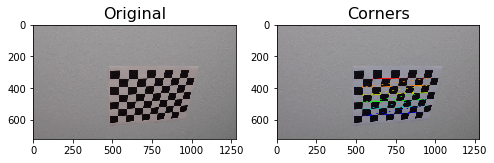

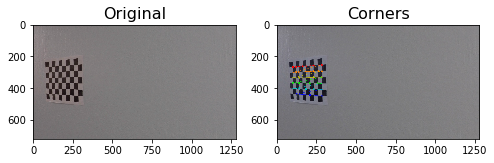

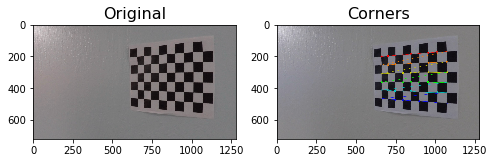

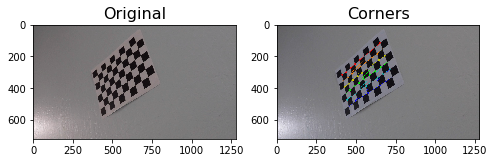

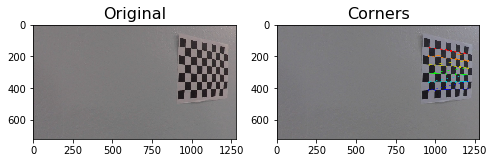

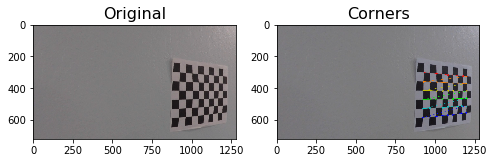

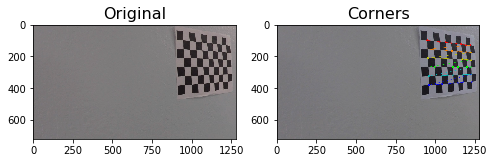

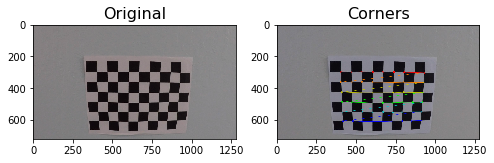

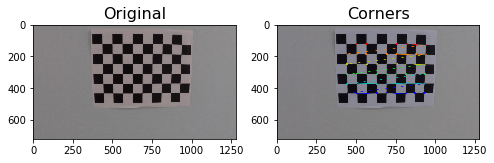

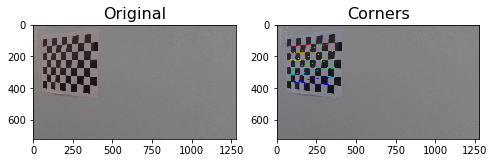

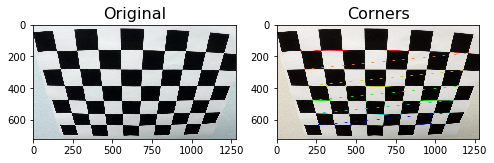

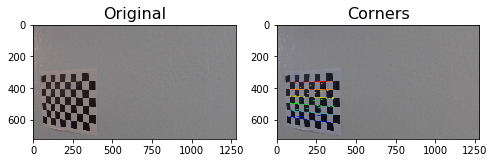

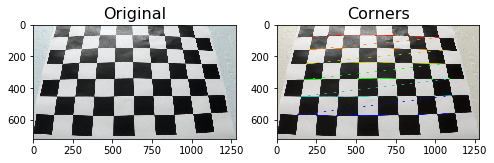

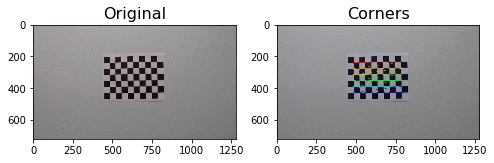

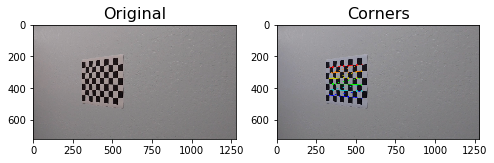

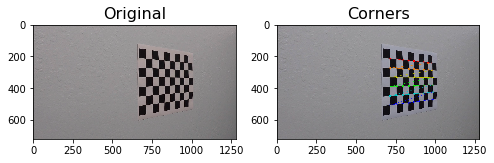

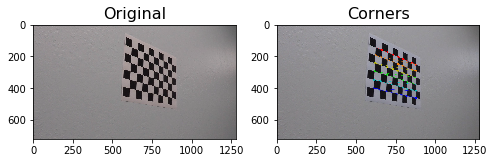

In [2]:
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

images = glob.glob('camera_cal/calibration*.jpg')

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
        ax1.imshow(cv2.cvtColor(mpimg.imread(fname), cv2.COLOR_BGR2RGB))
        ax1.set_title('Original', fontsize=16)
        ax2.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax2.set_title('Corners', fontsize=16)

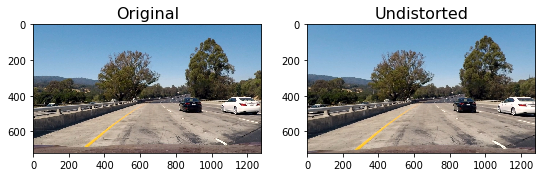

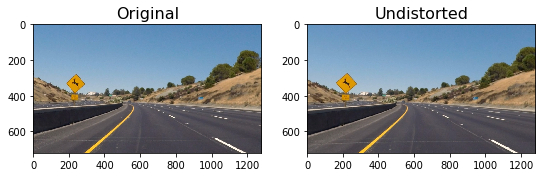

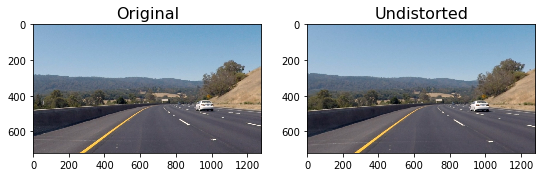

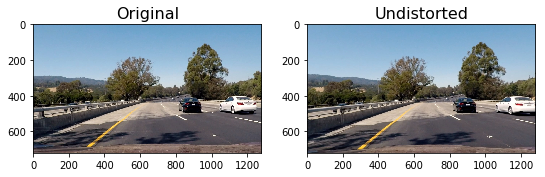

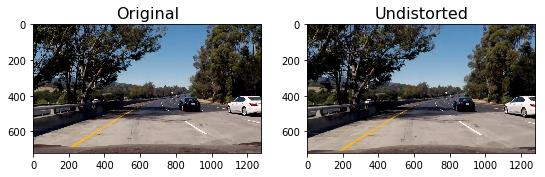

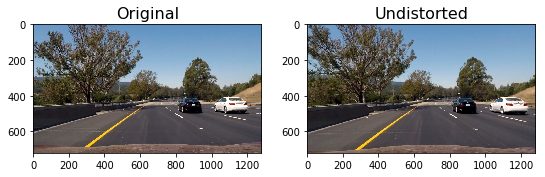

In [3]:
# to remove distortion
def undistort(image, show=True):
    img = cv2.imread(image)
    img_size = (img.shape[1], img.shape[0])
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if show:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9,6))
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax1.set_title('Original', fontsize=16)
        ax2.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax2.set_title('Undistorted', fontsize=16)
    else:
        return undist

# perform undistortion and display results
test_images = glob.glob('test_images/test*.jpg')
for test_image in test_images:
    undistort(test_image)

### Step 2: Perspective Transform

Define a function `transform()` to transforms the undistorted image to a "birds' eye view" of the road which makes it easier for fitting polynomials and measuring curvature.

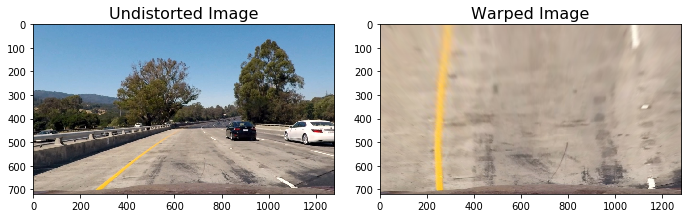

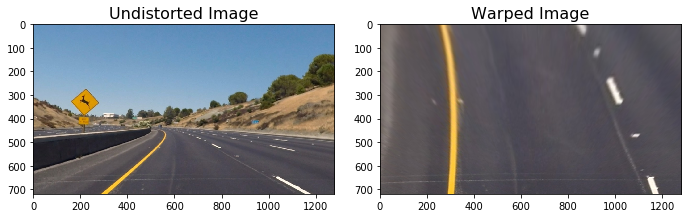

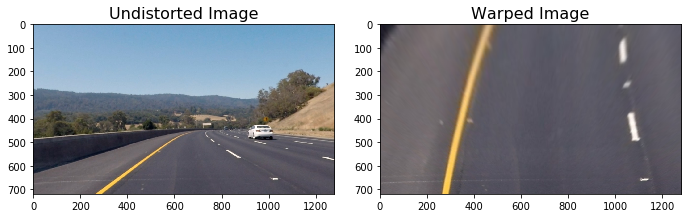

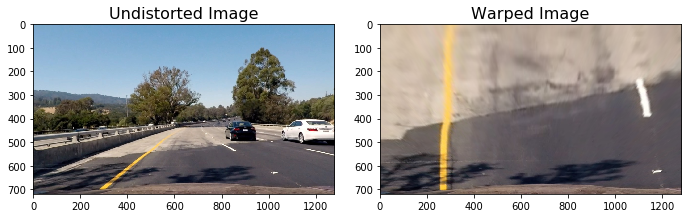

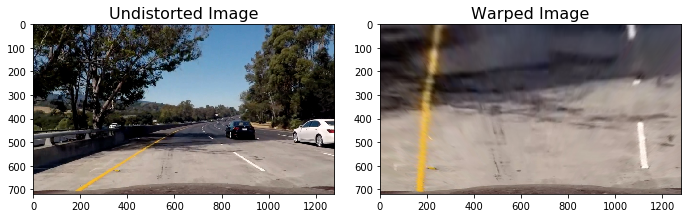

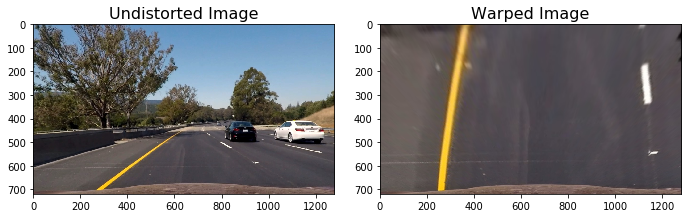

In [4]:
# Perform perspective transform
def transform(img, display=True):
    undist = undistort(img, show = False)
    img_size = (undist.shape[1], undist.shape[0])
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 6))
        f.tight_layout()
        ax1.imshow(cv2.cvtColor(undist, cv2.COLOR_BGR2RGB))
        ax1.set_title('Undistorted Image', fontsize=16)
        ax2.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
        ax2.set_title('Warped Image', fontsize=16)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    else:
        return warped, M
    
# perform perspective transform
for test_image in glob.glob('test_images/test*.jpg'):
    transform(test_image)

### Step 3: Binary Thresholds

Through many experiments and inspiration from Udacity forum, I use the following combined color channels and thresholds to identify the lane lines:

- The B channel from the Lab color space, with threshold of (150,200), which identifies yellow lines well but ignores white ones. 
- The L Channel from the LUV color space with threshold of (220,255),  which identifies white lines well but ignores yellow ones. 

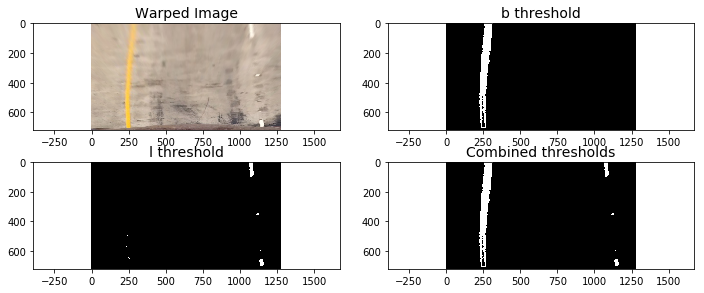

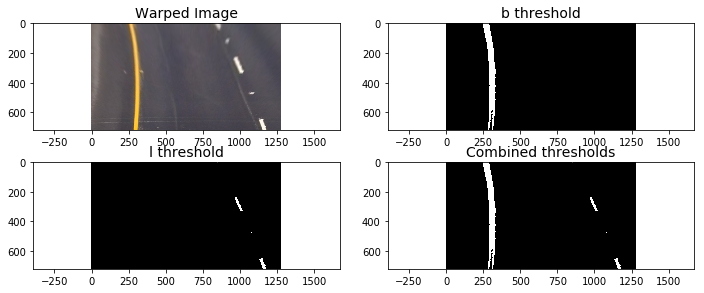

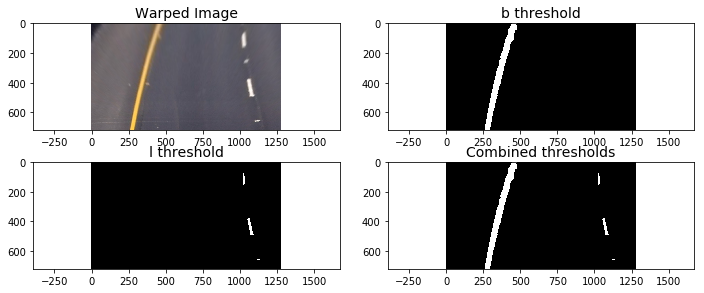

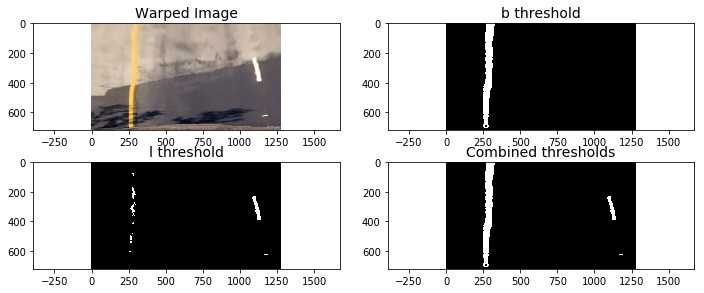

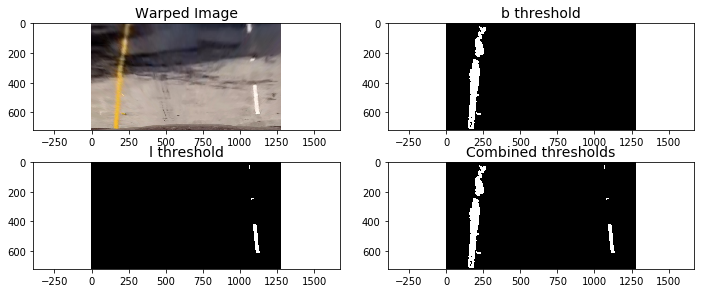

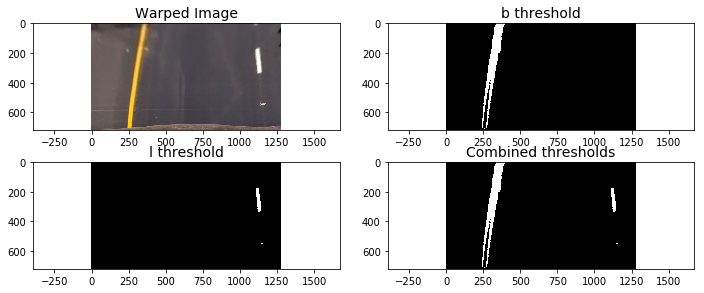

In [5]:
# Create binary thresholded images to isolate lane line pixels
def combined_thresholds(image, show=True):
    img, M = transform(image, display = False)
    
    l_channel = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)[:,:,0]
    b_channel = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)[:,:,2]   
    
    # B channel from Lab
    l_thresh_min = 220
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    
    # L channel from LUV  
    b_thresh_min = 150
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # combine the two thresholds
    combined_binary = np.zeros_like(l_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1

    if show == True:
        # Plotting thresholded images
        f, ((ax1, ax2), (ax3,ax4)) = plt.subplots(2, 2, sharey='col', sharex='row', figsize=(10,4))
        f.tight_layout()
        
        ax1.set_title('Warped Image', fontsize=14)
        ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype('uint8'))
        
        ax2.set_title('b threshold', fontsize=14)
        ax2.imshow(b_binary, cmap='gray')
        
        ax3.set_title('l threshold', fontsize=14)
        ax3.imshow(l_binary, cmap='gray')

        ax4.set_title('Combined thresholds', fontsize=14)
        ax4.imshow(combined_binary, cmap='gray')
        
    else: 
        return combined_binary
    
# perform the thresholds
for test_image in glob.glob('test_images/test*.jpg'):
    combined_thresholds(test_image)

### Step 4: Fit a polynomial to lane lines, calculate vehicle position and radius

Define function `fit_lanes()` to detect lane lines by identifying peaks in the histogram of image and detecting nonzero pixels close to the peaks. 

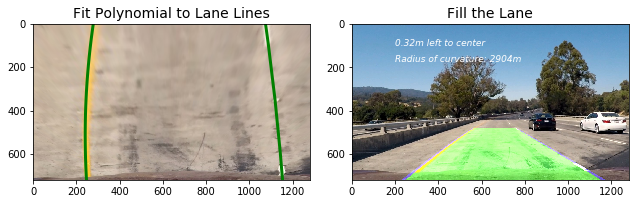

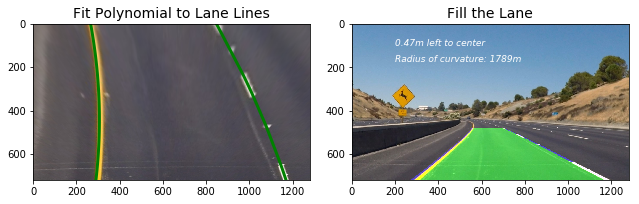

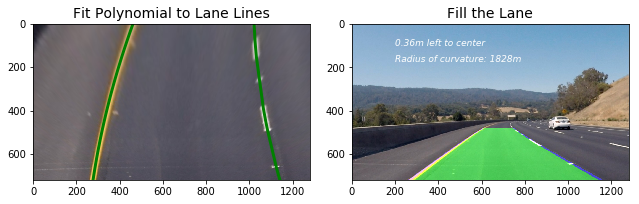

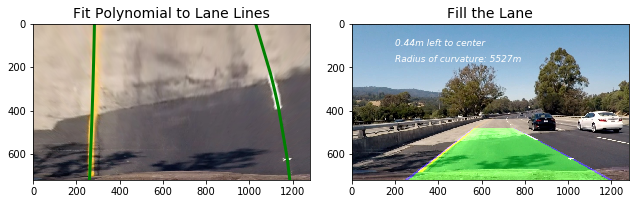

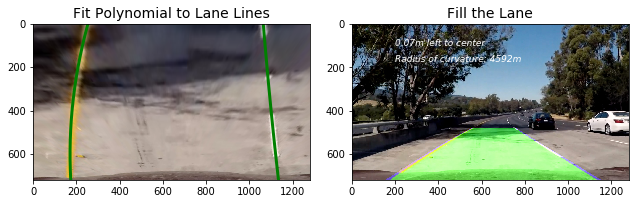

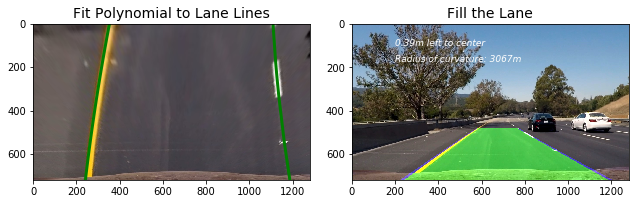

In [6]:
def fit_lanes(image):
    
    combined_binary = combined_thresholds(image, show=False)
    
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    x, y = np.nonzero(np.transpose(combined_binary))
    i = 720
    j = 630
    while j >= 0:
        histogram = np.sum(combined_binary[j:i,:], axis=0)
        left_peak = np.argmax(histogram[:640])
        x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            leftx.extend(x_window.tolist())
            lefty.extend(y_window.tolist())

        right_peak = np.argmax(histogram[640:]) + 640
        x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
        x_window, y_window = x[x_idx], y[x_idx]
        if np.sum(x_window) != 0:
            rightx.extend(x_window.tolist())
            righty.extend(y_window.tolist())
        i -= 90
        j -= 90

    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    
    rightx = np.append(rightx,rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx,right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2])
    righty = np.append(righty, 0)
    
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx,left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2])
    lefty = np.append(lefty, 0)
    
    lsort = np.argsort(lefty)
    rsort = np.argsort(righty)
    
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    righty = righty[rsort]
    rightx = rightx[rsort]
    
    # fit the left lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    # fit the right lane line
    right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    
    # measure radius of curvature for each lane line
    ym_per_pix = 30./720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700  # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    
    # compute position of the vehicle wrt the center of the lane
    center = abs(640 - ((rightx_int+leftx_int)/2))
    offset = 0 
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[40, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([left_fitx, lefty])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, righty]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (combined_binary.shape[1], combined_binary.shape[0]))
    result = cv2.addWeighted(mpimg.imread(image), 1, newwarp, 0.5, 0)
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(9, 6))
    f.tight_layout()
    ax1.imshow(cv2.cvtColor((transform(image, display=False)[0]), cv2.COLOR_BGR2RGB))
    ax1.set_xlim(0, 1280)
    ax1.set_ylim(0, 720)
    ax1.plot(left_fitx, lefty, color='green', linewidth=3)
    ax1.plot(right_fitx, righty, color='green', linewidth=3)
    ax1.set_title('Fit Polynomial to Lane Lines', fontsize=14)
    ax1.invert_yaxis() # to visualize as we do the images
    ax2.imshow(result)
    ax2.set_title('Fill the Lane', fontsize=14)
    if center < 640:
        ax2.text(200, 100, '{:.2f}m left to center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=9)
    else:
        ax2.text(200, 100, '{:.2f}m right to center'.format(center*3.7/700),
                 style='italic', color='white', fontsize=9)
    ax2.text(200, 175, 'Radius of curvature: {}m'.format(int((left_curverad + right_curverad)/2)),
             style='italic', color='white', fontsize=9)
    
# perform and display the results
for test_image in glob.glob('test_images/test*.jpg'):
    fit_lanes(test_image)

## Step 5: Video Processing

In [7]:
# define class to store attributes of left lane line from frame to frame
class Left:
    def __init__(self):
        # whether the line is found in the previous frame
        self.found = False
        
        # x and y of lanes in previous frame
        self.X = None
        self.Y = None
        
        # to store x's for filtering between frames
        self.x_int = []
        self.top = []
        
        # previous x to compare with current one
        self.lastx_int = None
        self.last_top = None
        
        # radius of curvature
        self.radius = None
        
        # to store recent polynomial coefficients
        self.fit0 = []
        self.fit1 = []
        self.fit2 = []
        self.fitx = None
        self.pts = []
        
        # number of frames
        self.count = 0

In [8]:
# define class to store attributes of right lane line from frame to frame
class Right:
    def __init__(self):
        # whether the line is found in the previous frame
        self.found = False
        
        # x and y of lanes in previous frame
        self.X = None
        self.Y = None
        
        # to store x's for filtering between frames
        self.x_int = []
        self.top = []
        
        # previous x to compare with current one
        self.lastx_int = None
        self.last_top = None
        
        # radius of curvature
        self.radius = None
        
        # to store recent polynomial coefficients
        self.fit0 = []
        self.fit1 = []
        self.fit2 = []
        self.fitx = None
        self.pts = []

In [9]:
# Define function `process_video()` to processe video frame by frame and outputs an annotated one with lane lines, 
# distance from center and radius of curvature. It checks for lane pixels in a tight window in the previous polynomials 
# for a confident detection. 

def process_video(image):
    img_size = (image.shape[1], image.shape[0])
    
    # Calibrate camera and undistort image
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    
    # Perform perspective transform
    offset = 0
    src = np.float32([[490, 482],[810, 482],
                      [1250, 720],[0, 720]])
    dst = np.float32([[0, 0], [1280, 0], 
                     [1250, 720],[40, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(undist, M, img_size)
    
    # Generate binary thresholded images
    b_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)[:,:,2]
    l_channel = cv2.cvtColor(warped, cv2.COLOR_RGB2LUV)[:,:,0]  
    
    # Set the upper and lower thresholds for the b channel
    b_thresh_min = 145
    b_thresh_max = 200
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    # Set the upper and lower thresholds for the l channel
    l_thresh_min = 215
    l_thresh_max = 255
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1

    combined_binary = np.zeros_like(b_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1)] = 1
    
    # Initialize empty lists for the lane line pixels
    rightx = []
    righty = []
    leftx = []
    lefty = []
    
    # Identify all non zero pixels in the image
    x, y = np.nonzero(np.transpose(combined_binary)) 

    if Left.found == True: # Search for left lane pixels around previous polynomial
        i = 720
        j = 630
        while j >= 0:
            yval = np.mean([i,j])
            xval = (np.mean(Left.fit0))*yval**2 + (np.mean(Left.fit1))*yval + (np.mean(Left.fit2))
            x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
            x_window, y_window = x[x_idx], y[x_idx]
            if np.sum(x_window) != 0:
                np.append(leftx, x_window)
                np.append(lefty, y_window)
            i -= 90
            j -= 90
        if np.sum(leftx) == 0: 
            Left.found = False # If no lane pixels were detected then perform blind search
        
    if Right.found == True: # Search for right lane pixels around previous polynomial
        i = 720
        j = 630
        while j >= 0:
            yval = np.mean([i,j])
            xval = (np.mean(Right.fit0))*yval**2 + (np.mean(Right.fit1))*yval + (np.mean(Right.fit2))
            x_idx = np.where((((xval - 25) < x)&(x < (xval + 25))&((y > j) & (y < i))))
            x_window, y_window = x[x_idx], y[x_idx]
            if np.sum(x_window) != 0:
                np.append(rightx, x_window)
                np.append(righty, y_window)
            
            i -= 90
            j -= 90
        if np.sum(rightx) == 0:
            Right.found = False # If no lane pixels were detected then perform blind search
            
    if Right.found == False: # Perform blind search for lane lines
        i = 720
        j = 630
        while j >= 0:
            histogram = np.sum(combined_binary[j:i,:], axis=0)
            right_peak = np.argmax(histogram[640:]) + 640
            x_idx = np.where((((right_peak - 25) < x)&(x < (right_peak + 25))&((y > j) & (y < i))))
            x_window, y_window = x[x_idx], y[x_idx]
            if np.sum(x_window) != 0:
                rightx.extend(x_window.tolist())
                righty.extend(y_window.tolist())
            i -= 90
            j -= 90
    if not np.sum(righty) > 0:
        righty = Right.Y
        rightx = Right.X
            
    if Left.found == False:# Perform blind search for lane lines
        i = 720
        j = 630
        while j >= 0:
            histogram = np.sum(combined_binary[j:i,:], axis=0)
            left_peak = np.argmax(histogram[:640])
            x_idx = np.where((((left_peak - 25) < x)&(x < (left_peak + 25))&((y > j) & (y < i))))
            x_window, y_window = x[x_idx], y[x_idx]
            if np.sum(x_window) != 0:
                leftx.extend(x_window.tolist())
                lefty.extend(y_window.tolist())
            i -= 90
            j -= 90
    if not np.sum(lefty) > 0:
        lefty = Left.Y
        leftx = Left.X
        
    lefty = np.array(lefty).astype(np.float32)
    leftx = np.array(leftx).astype(np.float32)
    righty = np.array(righty).astype(np.float32)
    rightx = np.array(rightx).astype(np.float32)
            
    # Calculate left polynomial fit based on detected pixels
    left_fit = np.polyfit(lefty, leftx, 2)
    
    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    leftx_int = left_fit[0]*720**2 + left_fit[1]*720 + left_fit[2]
    left_top = left_fit[0]*0**2 + left_fit[1]*0 + left_fit[2]
    
    # Average intercepts across 5 frames
    Left.x_int.append(leftx_int)
    Left.top.append(left_top)
    leftx_int = np.mean(Left.x_int)
    left_top = np.mean(Left.top)
    Left.lastx_int = leftx_int
    Left.last_top = left_top
    leftx = np.append(leftx, leftx_int)
    lefty = np.append(lefty, 720)
    leftx = np.append(leftx, left_top)
    lefty = np.append(lefty, 0)
    lsort = np.argsort(lefty)
    lefty = lefty[lsort]
    leftx = leftx[lsort]
    Left.X = leftx
    Left.Y = lefty
    
    # Recalculate polynomial with intercepts and average across 5 frames
    left_fit = np.polyfit(lefty, leftx, 2)
    Left.fit0.append(left_fit[0])
    Left.fit1.append(left_fit[1])
    Left.fit2.append(left_fit[2])
    left_fit = [np.mean(Left.fit0), 
                np.mean(Left.fit1), 
                np.mean(Left.fit2)]
    
    # Fit polynomial to detected pixels
    left_fitx = left_fit[0]*lefty**2 + left_fit[1]*lefty + left_fit[2]
    Left.fitx = left_fitx
    
    # Calculate right polynomial fit based on detected pixels
    right_fit = np.polyfit(np.int_(righty), np.int_(rightx), 2)

    # Calculate intercepts to extend the polynomial to the top and bottom of warped image
    rightx_int = right_fit[0]*720**2 + right_fit[1]*720 + right_fit[2]
    right_top = right_fit[0]*0**2 + right_fit[1]*0 + right_fit[2]
    
    # Average intercepts across 5 frames
    Right.x_int.append(rightx_int)
    rightx_int = np.mean(Right.x_int)
    Right.top.append(right_top)
    right_top = np.mean(Right.top)
    Right.lastx_int = rightx_int
    Right.last_top = right_top
    rightx = np.append(rightx, rightx_int)
    righty = np.append(righty, 720)
    rightx = np.append(rightx, right_top)
    righty = np.append(righty, 0)
    rsort = np.argsort(righty)
    righty = righty[rsort]
    rightx = rightx[rsort]
    Right.X = rightx
    Right.Y = righty
    
    # Recalculate polynomial with intercepts and average across 5 frames
    right_fit = np.polyfit(righty, rightx, 2)
    Right.fit0.append(right_fit[0])
    Right.fit1.append(right_fit[1])
    Right.fit2.append(right_fit[2])
    right_fit = [np.mean(Right.fit0), np.mean(Right.fit1), np.mean(Right.fit2)]
    
    # Fit polynomial to detected pixels
    right_fitx = right_fit[0]*righty**2 + right_fit[1]*righty + right_fit[2]
    Right.fitx = right_fitx
        
    # Compute radius of curvature for each lane in meters
    ym_per_pix = 30./720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    left_curverad = ((1 + (2*left_fit_cr[0]*np.max(lefty) + left_fit_cr[1])**2)**1.5)/np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*np.max(lefty) + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])
        
    # Only print the radius of curvature every 3 frames for improved readability
    if Left.count % 3 == 0:
        Left.radius = left_curverad
        Right.radius = right_curverad
        
    # Calculate the vehicle position relative to the center of the lane
    position = (rightx_int+leftx_int)/2
    distance_from_center = abs((640 - position)*3.7/700) 
                
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warp_zero = np.zeros_like(combined_binary).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    pts_left = np.array([np.flipud(np.transpose(np.vstack([Left.fitx, Left.Y])))])
    pts_right = np.array([np.transpose(np.vstack([right_fitx, Right.Y]))])
    pts = np.hstack((pts_left, pts_right))
    cv2.polylines(color_warp, np.int_([pts]), isClosed=False, color=(0,0,255), thickness = 40)
    cv2.fillPoly(color_warp, np.int_(pts), (34,255,34))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    
    
    # Remember recent polynomial coefficients and intercepts
    if len(Left.fit0) > 10:
        Left.fit0 = Left.fit0[1:]
    if len(Left.fit1) > 10:
        Left.fit1 = Left.fit1[1:]
    if len(Left.fit2) > 10:
        Left.fit2 = Left.fit2[1:]
    if len(Left.x_int) > 50:
        Left.x_int = Left.x_int[1:]
    if len(Left.top) > 50:
        Left.top = Left.top[1:]
    if len(Right.fit0) > 10:
        Right.fit0 = Right.fit0[1:]
    if len(Right.fit1) > 10:
        Right.fit1 = Right.fit1[1:]
    if len(Right.fit2) > 10:
        Right.fit2 = Right.fit2[1:]
    if len(Right.x_int) > 50:
        Right.x_int = Right.x_int[1:]
    if len(Right.top) > 50:
        Right.top = Right.top[1:]
        
    # Print distance from center on video
    if position > 640:
        cv2.putText(result, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    else:
        cv2.putText(result, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (100,80),
                 fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    # Print radius of curvature on video
    cv2.putText(result, 'Radius of Curvature is {}(m)'.format(int((Left.radius+Right.radius)/2)), (120,140),
             fontFace = 16, fontScale = 2, color=(255,255,255), thickness = 2)
    Left.count += 1
    return result

Process the video and display the results for 'project_video'.

In [10]:
Left.__init__(Left)
Right.__init__(Right)
video_output = 'annotated_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_video) 
white_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video annotated_video.mp4
[MoviePy] Writing video annotated_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [20:25<00:00,  1.06it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: annotated_video.mp4 



In [11]:
# display the video
from IPython.display import HTML
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('annotated_video.mp4'))

Process the video and display the results for 'challenge_video'.

In [12]:
Left.__init__(Left)
Right.__init__(Right)
challenge_output = 'annotated_challenge_video.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
challenge_clip = clip1.fl_image(process_video) 
challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video annotated_challenge_video.mp4
[MoviePy] Writing video annotated_challenge_video.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 485/485 [07:34<00:00,  1.08it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: annotated_challenge_video.mp4 



In [13]:
# display the video
HTML("""
<video width="640" height="360" controls>
  <source src="{0}">
</video>
""".format('annotated_challenge_video.mp4'))